# Training Visualization and Analysis

In [150]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping

In [151]:
"""
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Reshape and normalize the data
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
"""


import cnn_module as cnn
import importlib
importlib.reload(cnn)
# Load and Preprocess the minist dataset
train_data, validation_data, test_data = cnn.preprocess_mnist()


# Step decay schedule
def step_decay_schedule(initial_lr=0.001, decay_factor=0.5, step_size=5):
    def schedule(epoch):
        return initial_lr * (decay_factor ** (epoch // step_size))
    return schedule

# Exponential decay schedule
def exponential_decay_schedule(initial_lr=0.001, decay_rate=0.95):
    def schedule(epoch):
        return initial_lr * (decay_rate ** epoch)
    return schedule

# Create and train a CNN model 
def create_and_train_model(learning_rate=0.001):
    model = keras.Sequential([
        # First Convolutional Block
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', name='conv1', 
                           input_shape=(28, 28, 1)),
        keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool1'),
        
        # Second Convolutional Block
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='conv2'),
        keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool2'),
        
        # Third Convolutional Block
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='conv3'),
        keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool3'),
        
        # Flatten the output to feed into dense layers
        keras.layers.Flatten(name='flatten'),
        
        # Fully connected layers
        keras.layers.Dense(128, activation='relu', name='dense1'),
        keras.layers.Dropout(0.5, name='dropout'),  # Dropout for regularization
        
        # Output layer
        keras.layers.Dense(10, activation='softmax', name='output')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    """
    # Step decay: reduce learning rate after fixed intervals
    lr_scheduler = LearningRateScheduler(
            step_decay_schedule(initial_lr=learning_rate),
            verbose=1
        )
    """
    # Exponential decay: continuously reduce learning rate
    lr_scheduler = LearningRateScheduler(
        exponential_decay_schedule(initial_lr=learning_rate),
        verbose=1
    )

    # Add early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    
    # Train the model with a small subset for demonstration
    validation_inputs, validation_targets = next(iter(validation_data))
    history = model.fit(
        train_data,
        epochs=20,
        #batch_size=100,
        validation_data=(validation_inputs, validation_targets),
        callbacks=[lr_scheduler, early_stopping],
        verbose=2
    )
    
    return model, history

In [152]:
model, history = create_and_train_model()


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
540/540 - 19s - loss: 0.2997 - accuracy: 0.9049 - val_loss: 0.0637 - val_accuracy: 0.9785 - lr: 0.0010 - 19s/epoch - 36ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.00095.
Epoch 2/20
540/540 - 19s - loss: 0.0834 - accuracy: 0.9755 - val_loss: 0.0432 - val_accuracy: 0.9865 - lr: 9.5000e-04 - 19s/epoch - 35ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0009025.
Epoch 3/20
540/540 - 18s - loss: 0.0585 - accuracy: 0.9831 - val_loss: 0.0271 - val_accuracy: 0.9912 - lr: 9.0250e-04 - 18s/epoch - 34ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.000857375.
Epoch 4/20
540/540 - 18s - loss: 0.0466 - accuracy: 0.9871 - val_loss: 0.0266 - val_accuracy: 0.9918 - lr: 8.5737e-04 - 18s/epoch - 34ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.0008145062499999999.
Epoch 5/20
540/540 - 18s - loss: 0.0358 - accuracy: 0.9891 - val_loss: 0.0224 - val_accu

In [153]:
model.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.002839036>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.999>}

In [154]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
print(f"\nFinal model test accuracy: {test_accuracy:.4f}")

1/1 [==============================] - 1s 965ms/step - loss: 0.0258 - accuracy: 0.9943

Final model test accuracy: 0.9943


In [155]:
model.save('temp.h5')

C:\Users\josep\anaconda3\envs\TF2.0\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 1. Visualize Filter Weights

In [157]:
# 1. Visualize Filter Weights from First Layer
def visualize_filters(model):
    # Get the weights from the first convolutional layer
    filters, biases = model.layers[0].get_weights()
    
    # Normalize filter values to 0-1 for visualization
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    
    # Plot the filters
    n_filters = filters.shape[3]
    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    
    for i in range(n_filters):
        ax = axes[i // 8, i % 8]
        ax.imshow(filters[:,:,0,i], cmap='gray')
        ax.axis('off')
    
    plt.suptitle('Conv1 Layer Filters', fontsize=16)
    plt.tight_layout()
    plt.show()

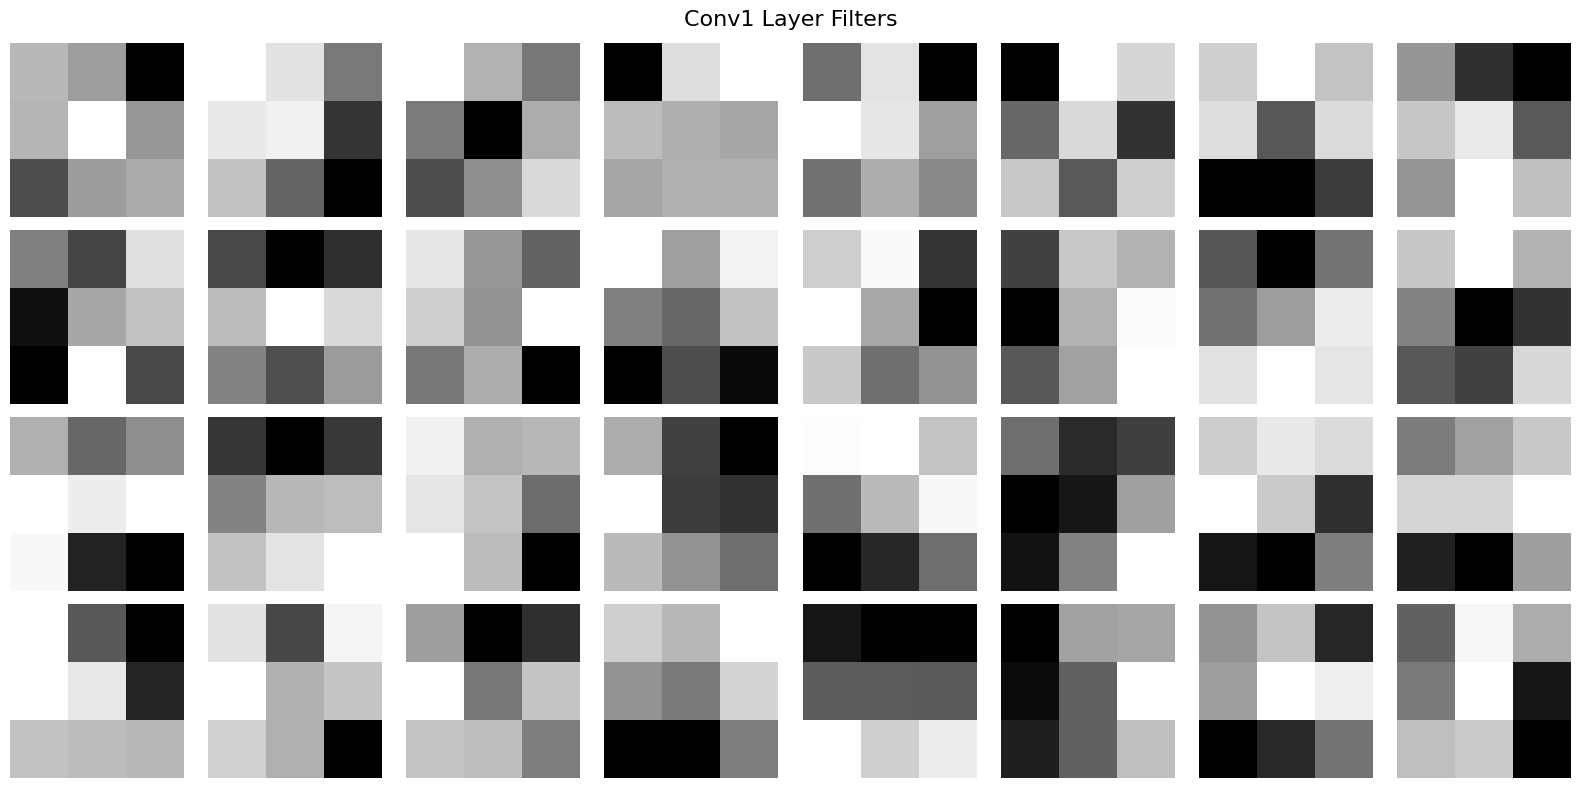

In [158]:
visualize_filters(model)

Filter Visualization Analysis:

- The first convolutional layer learns basic feature detectors like edges, curves, and textures
- Lighter areas show where the filter activates (positive values)
- Darker areas show where the filter suppresses (negative values)
- These filters are the foundation for all higher-level features detected in deeper layers

## 2. Feature Maps/Activations Visualization

In [161]:
# 2. Feature Maps/Activations Visualization
def visualize_feature_maps(model, img_idx=0):
    # Get a test image
    img = x_test[img_idx:img_idx+1]
    
    # Create models to extract activations from different layers
    activation_models = {}
    for layer_name in ['conv1', 'pool1', 'conv2', 'pool2', 'conv3', 'pool3']:
        activation_models[layer_name] = Model(
            inputs=model.input,
            outputs=model.get_layer(layer_name).output
        )
    
    # Get activations for the test image
    activations = {}
    for layer_name, activation_model in activation_models.items():
        activations[layer_name] = activation_model.predict(img)
    
    # Display the original image
    plt.figure(figsize=(5, 5))
    plt.imshow(x_test[img_idx].reshape(28, 28), cmap='gray')
    plt.title(f'Original Image (Digit: {y_test[img_idx]})')
    plt.axis('off')
    plt.show()
    
    # Display activations for each layer
    for layer_name, activation in activations.items():
        n_features = activation.shape[3]
        size = activation.shape[1]
        
        # Calculate grid dimensions based on number of features
        grid_size = int(np.ceil(np.sqrt(n_features)))
        
        # Display up to 64 feature maps (8x8 grid)
        n_cols = min(grid_size, 8)
        n_rows = min((n_features + n_cols - 1) // n_cols, 8)
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows))
        fig.suptitle(f'Feature Maps: {layer_name}', fontsize=16)
        
        for i in range(n_rows * n_cols):
            if i < n_features:
                if n_rows > 1:
                    ax = axes[i // n_cols, i % n_cols]
                else:
                    ax = axes[i % n_cols]
                ax.imshow(activation[0, :, :, i], cmap='viridis')
                ax.set_title(f'Filter {i}')
                ax.axis('off')
            else:
                if n_rows > 1:
                    axes[i // n_cols, i % n_cols].axis('off')
                else:
                    axes[i % n_cols].axis('off')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

1/1 [==============================] - 0s 54ms/step


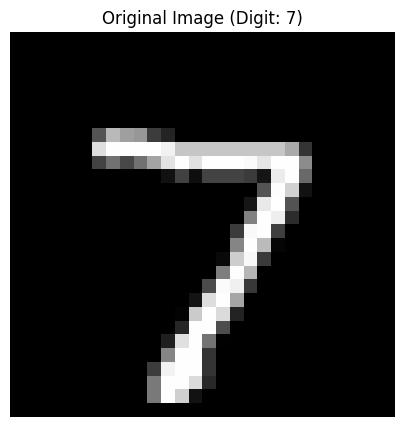

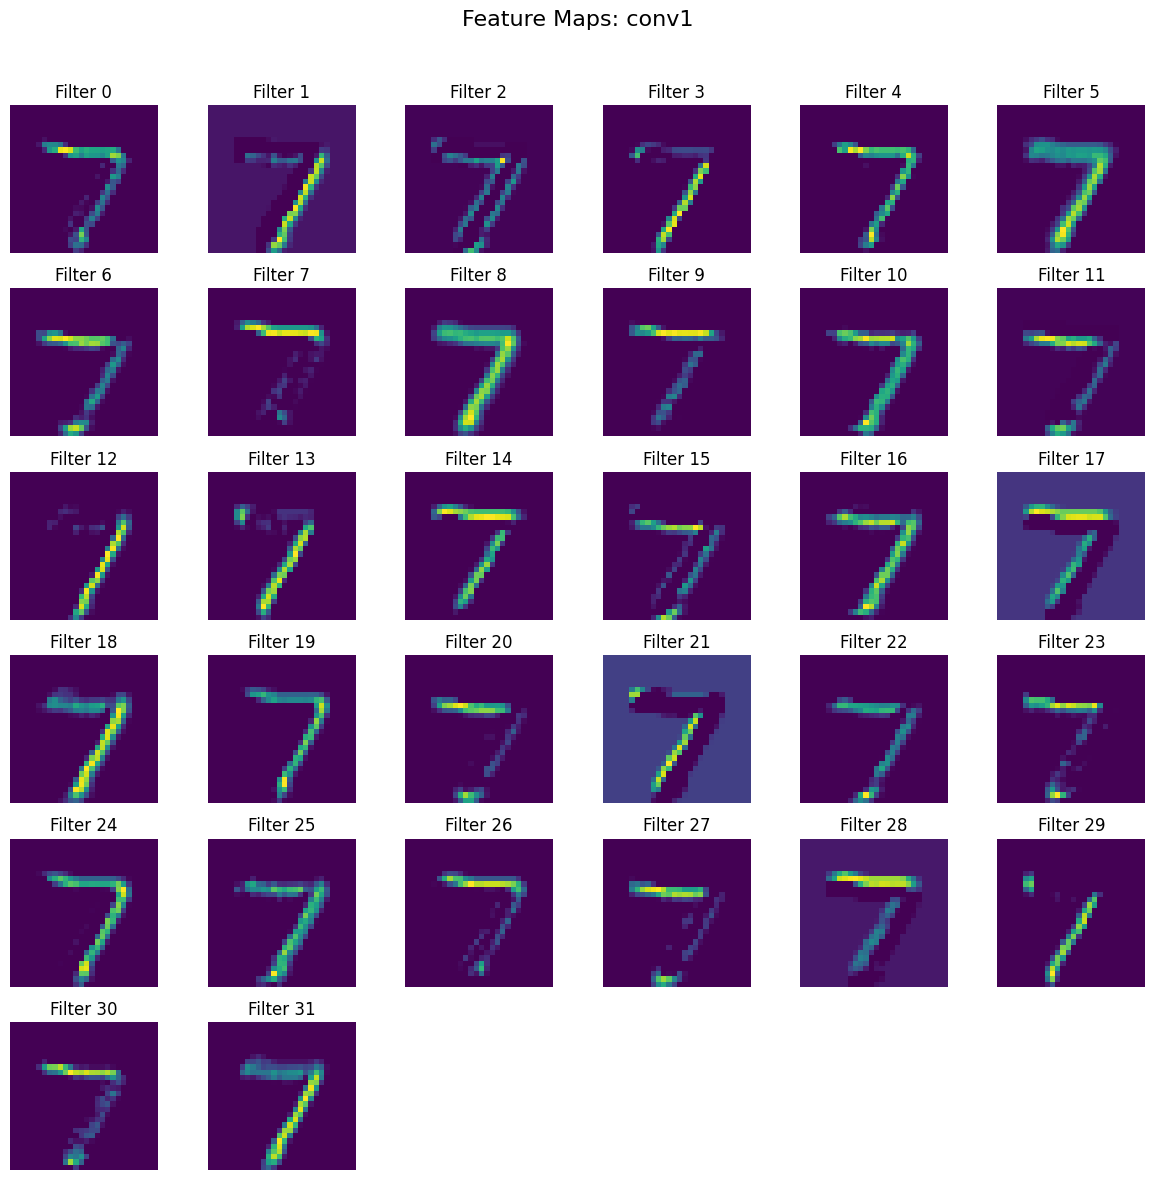

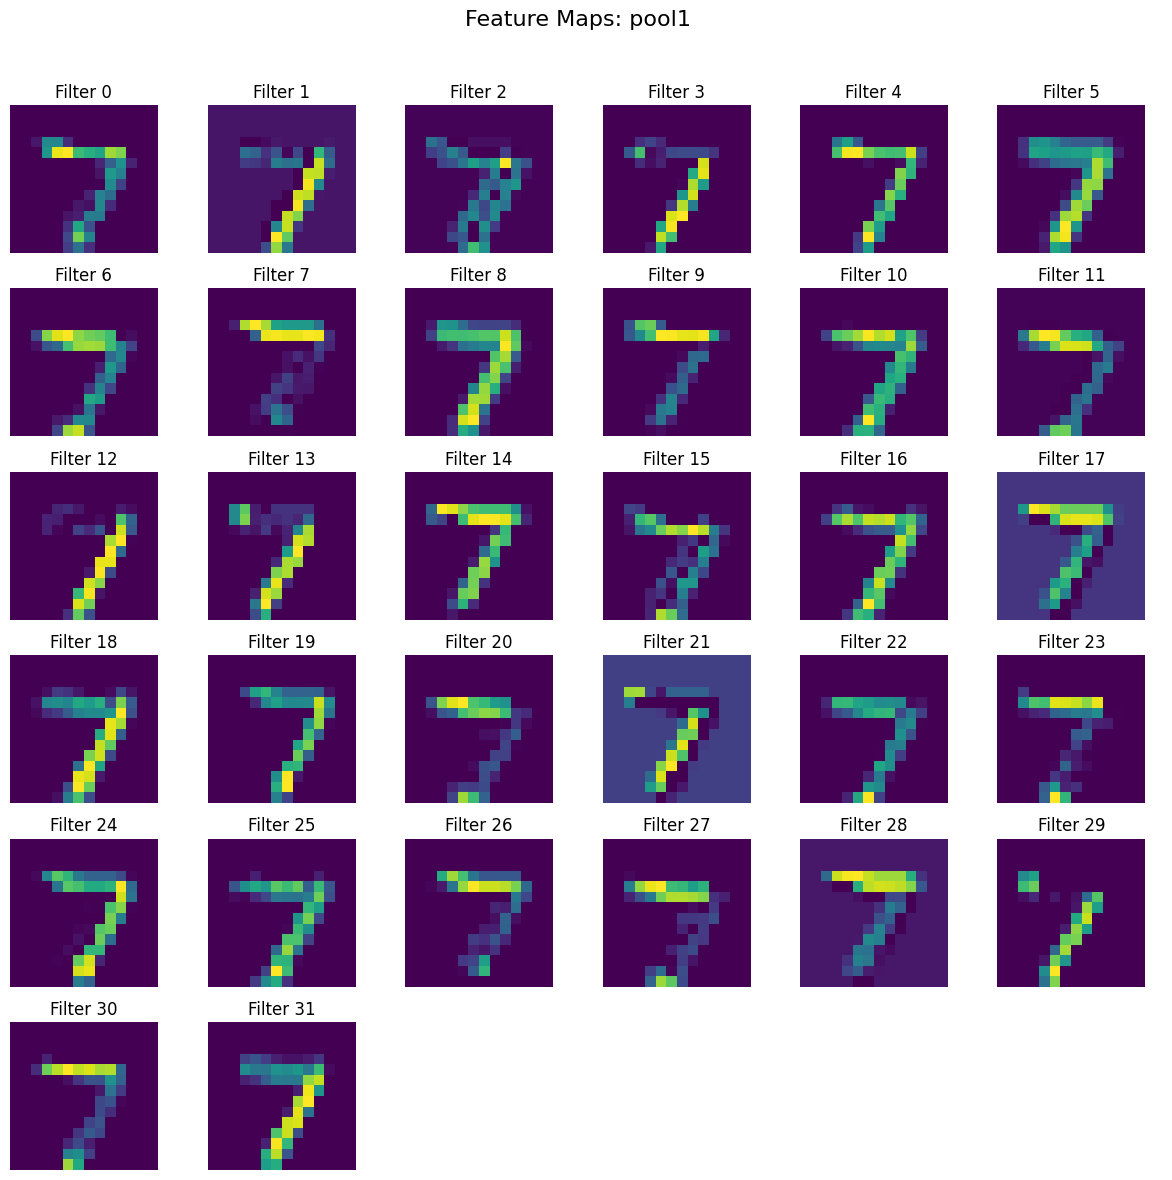

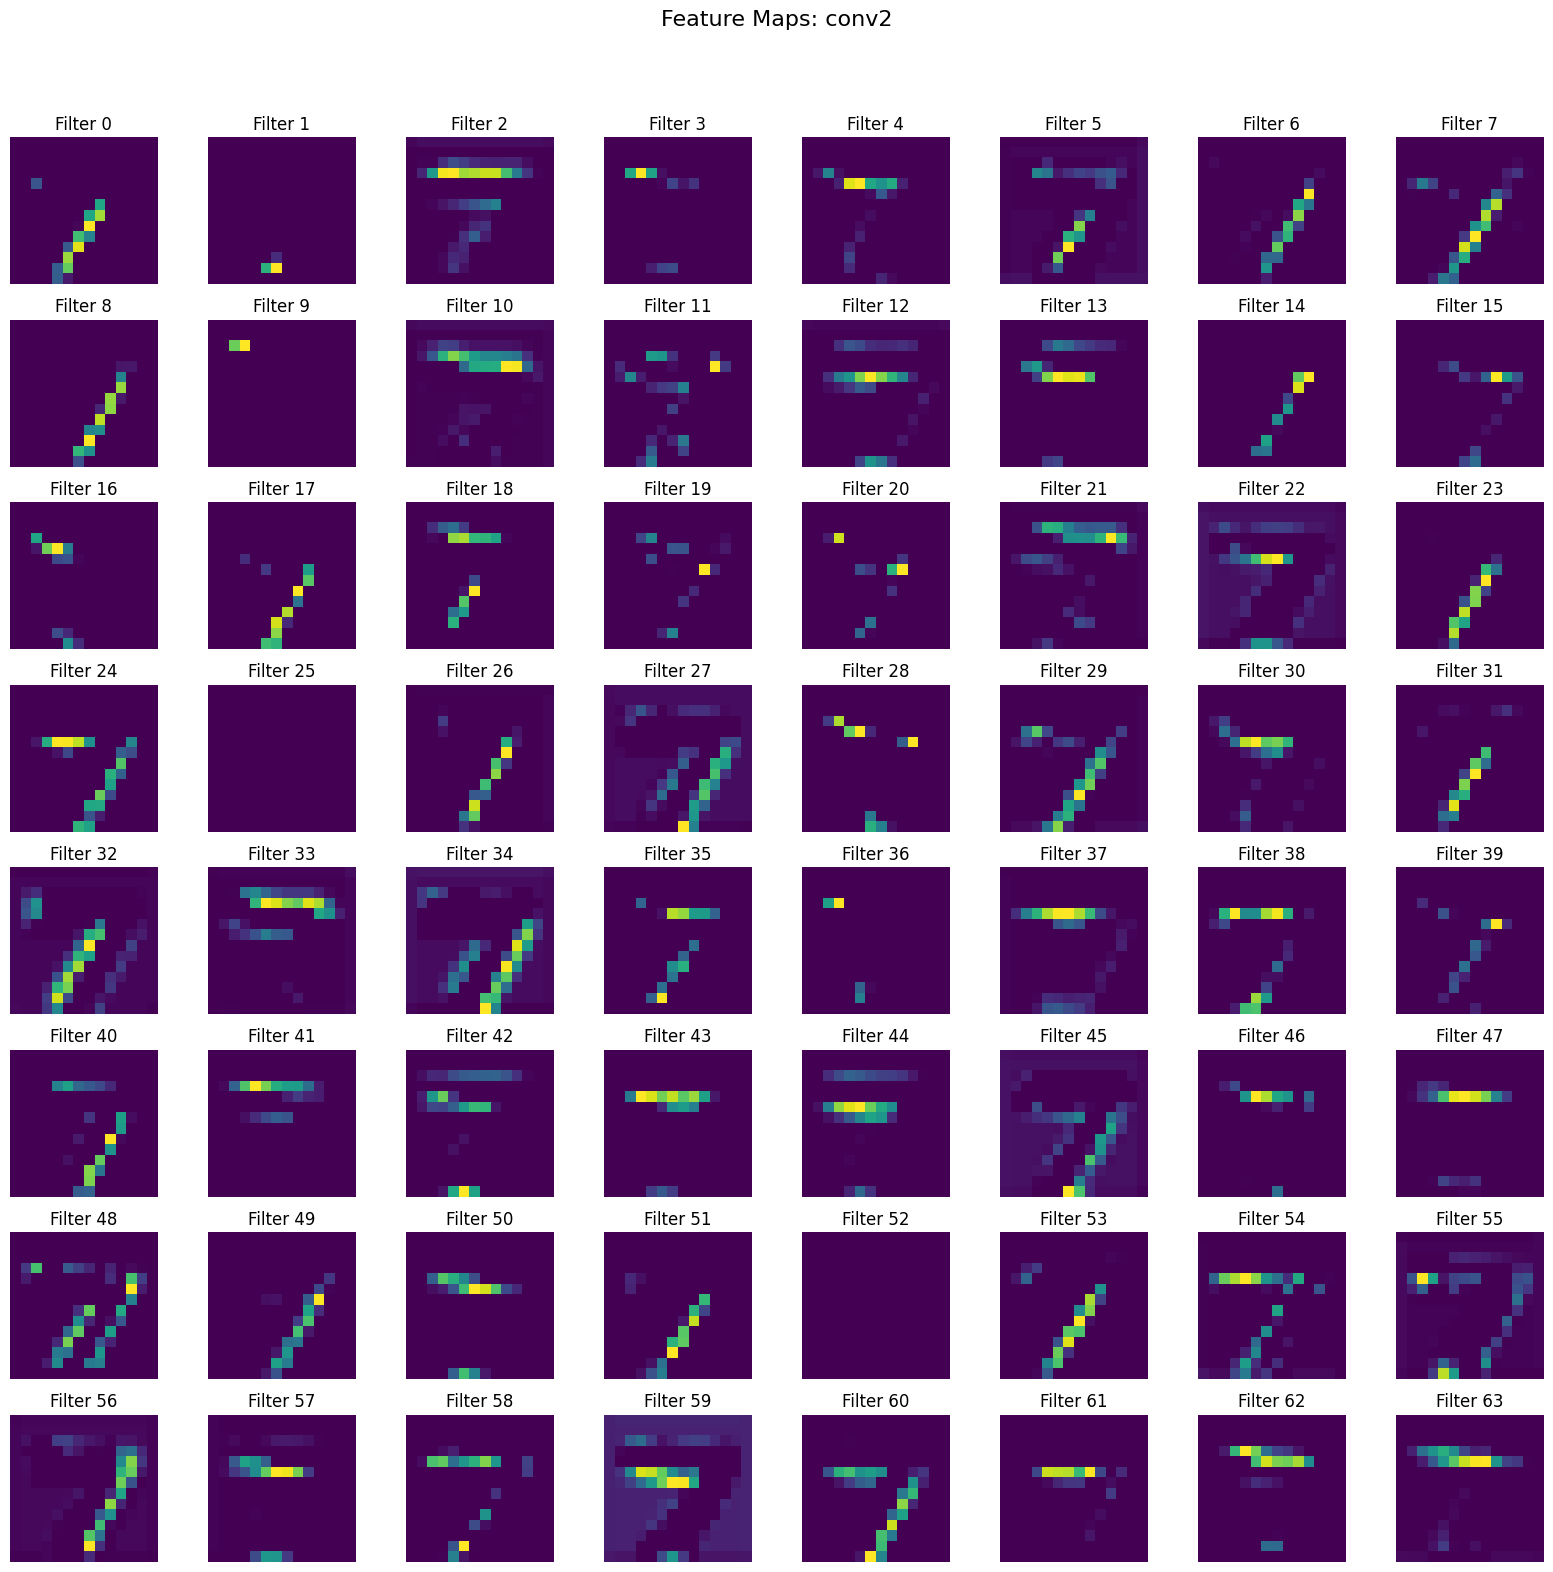

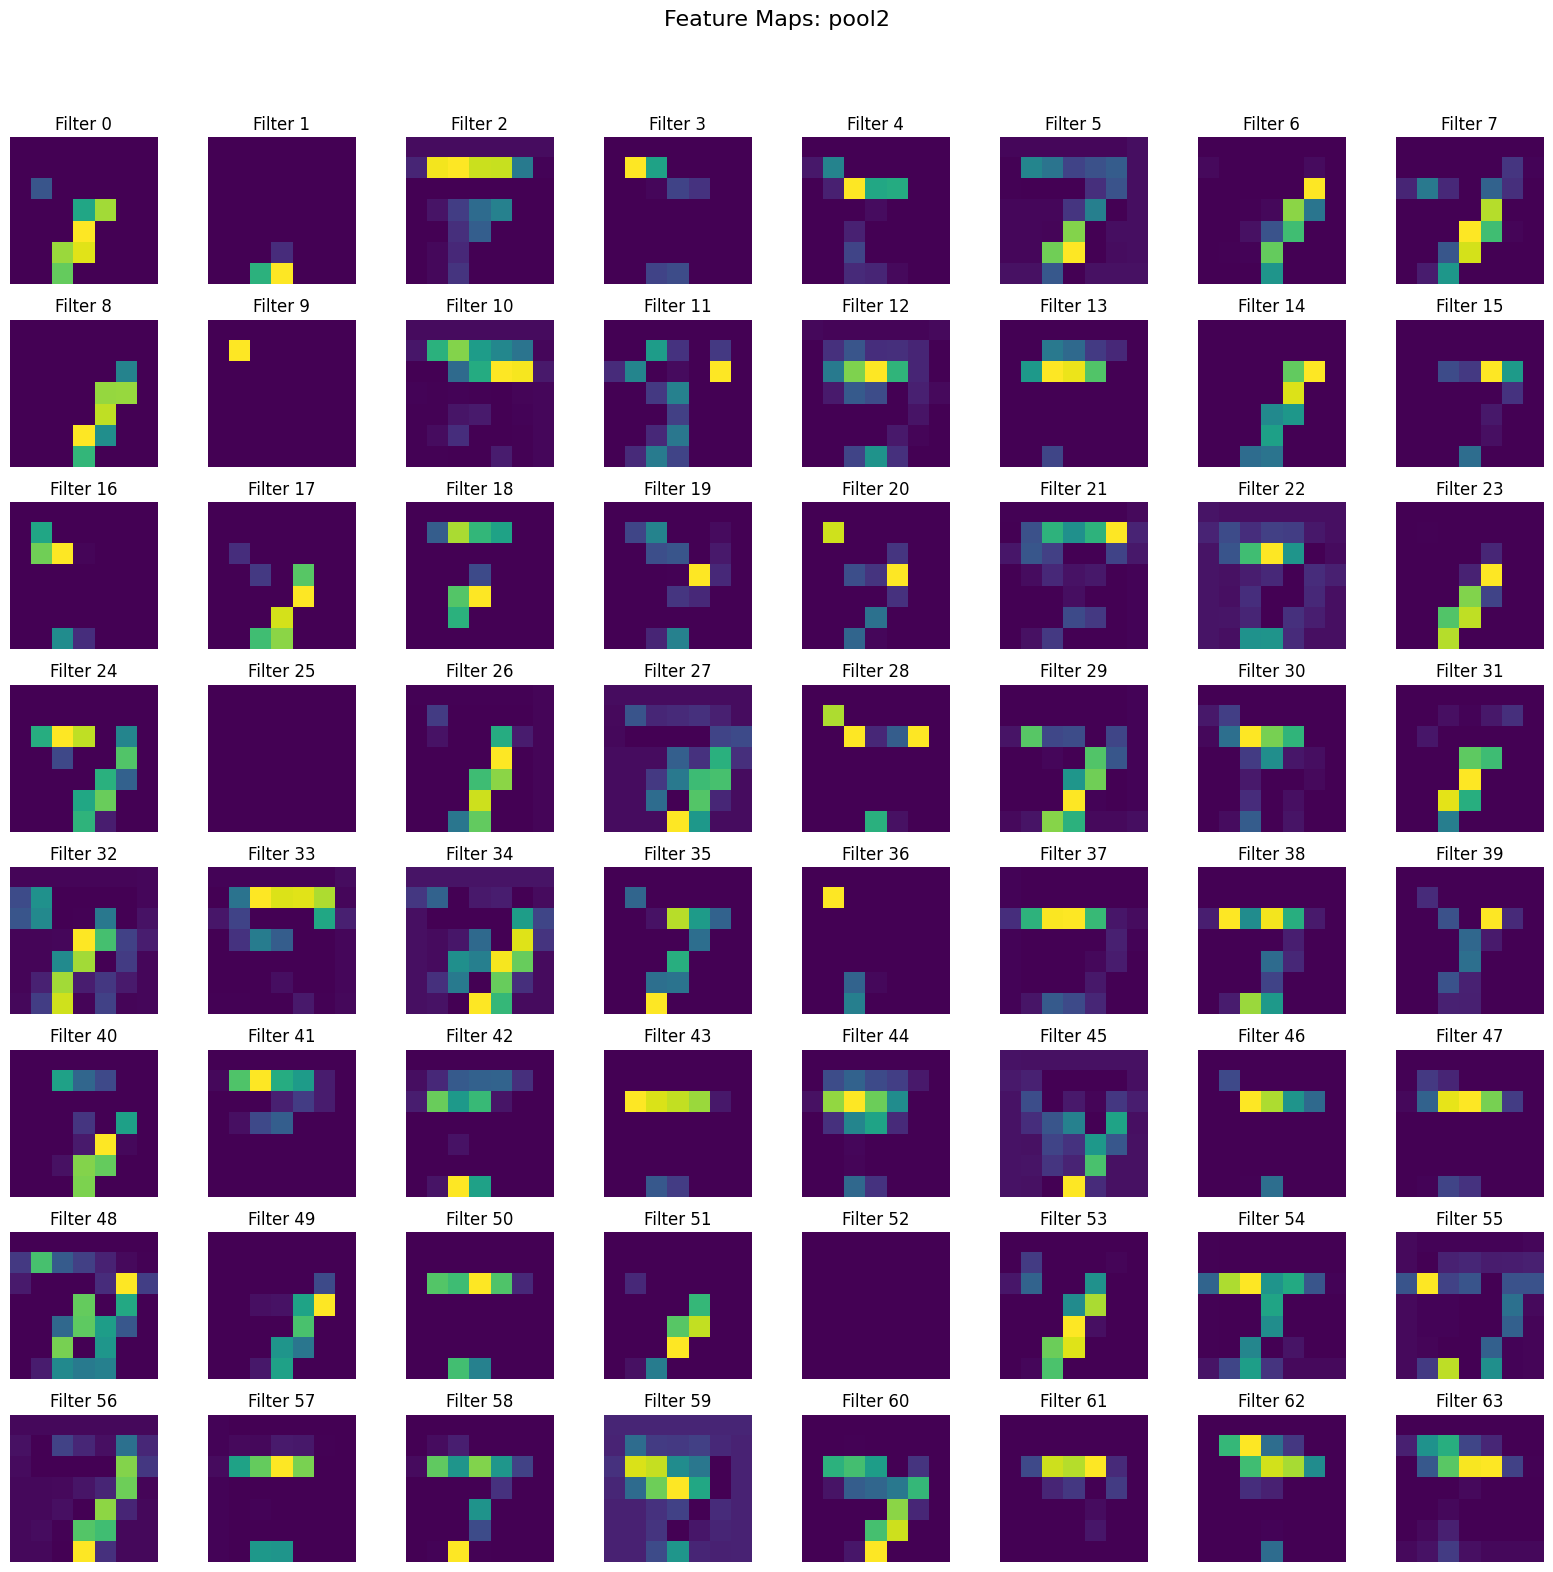

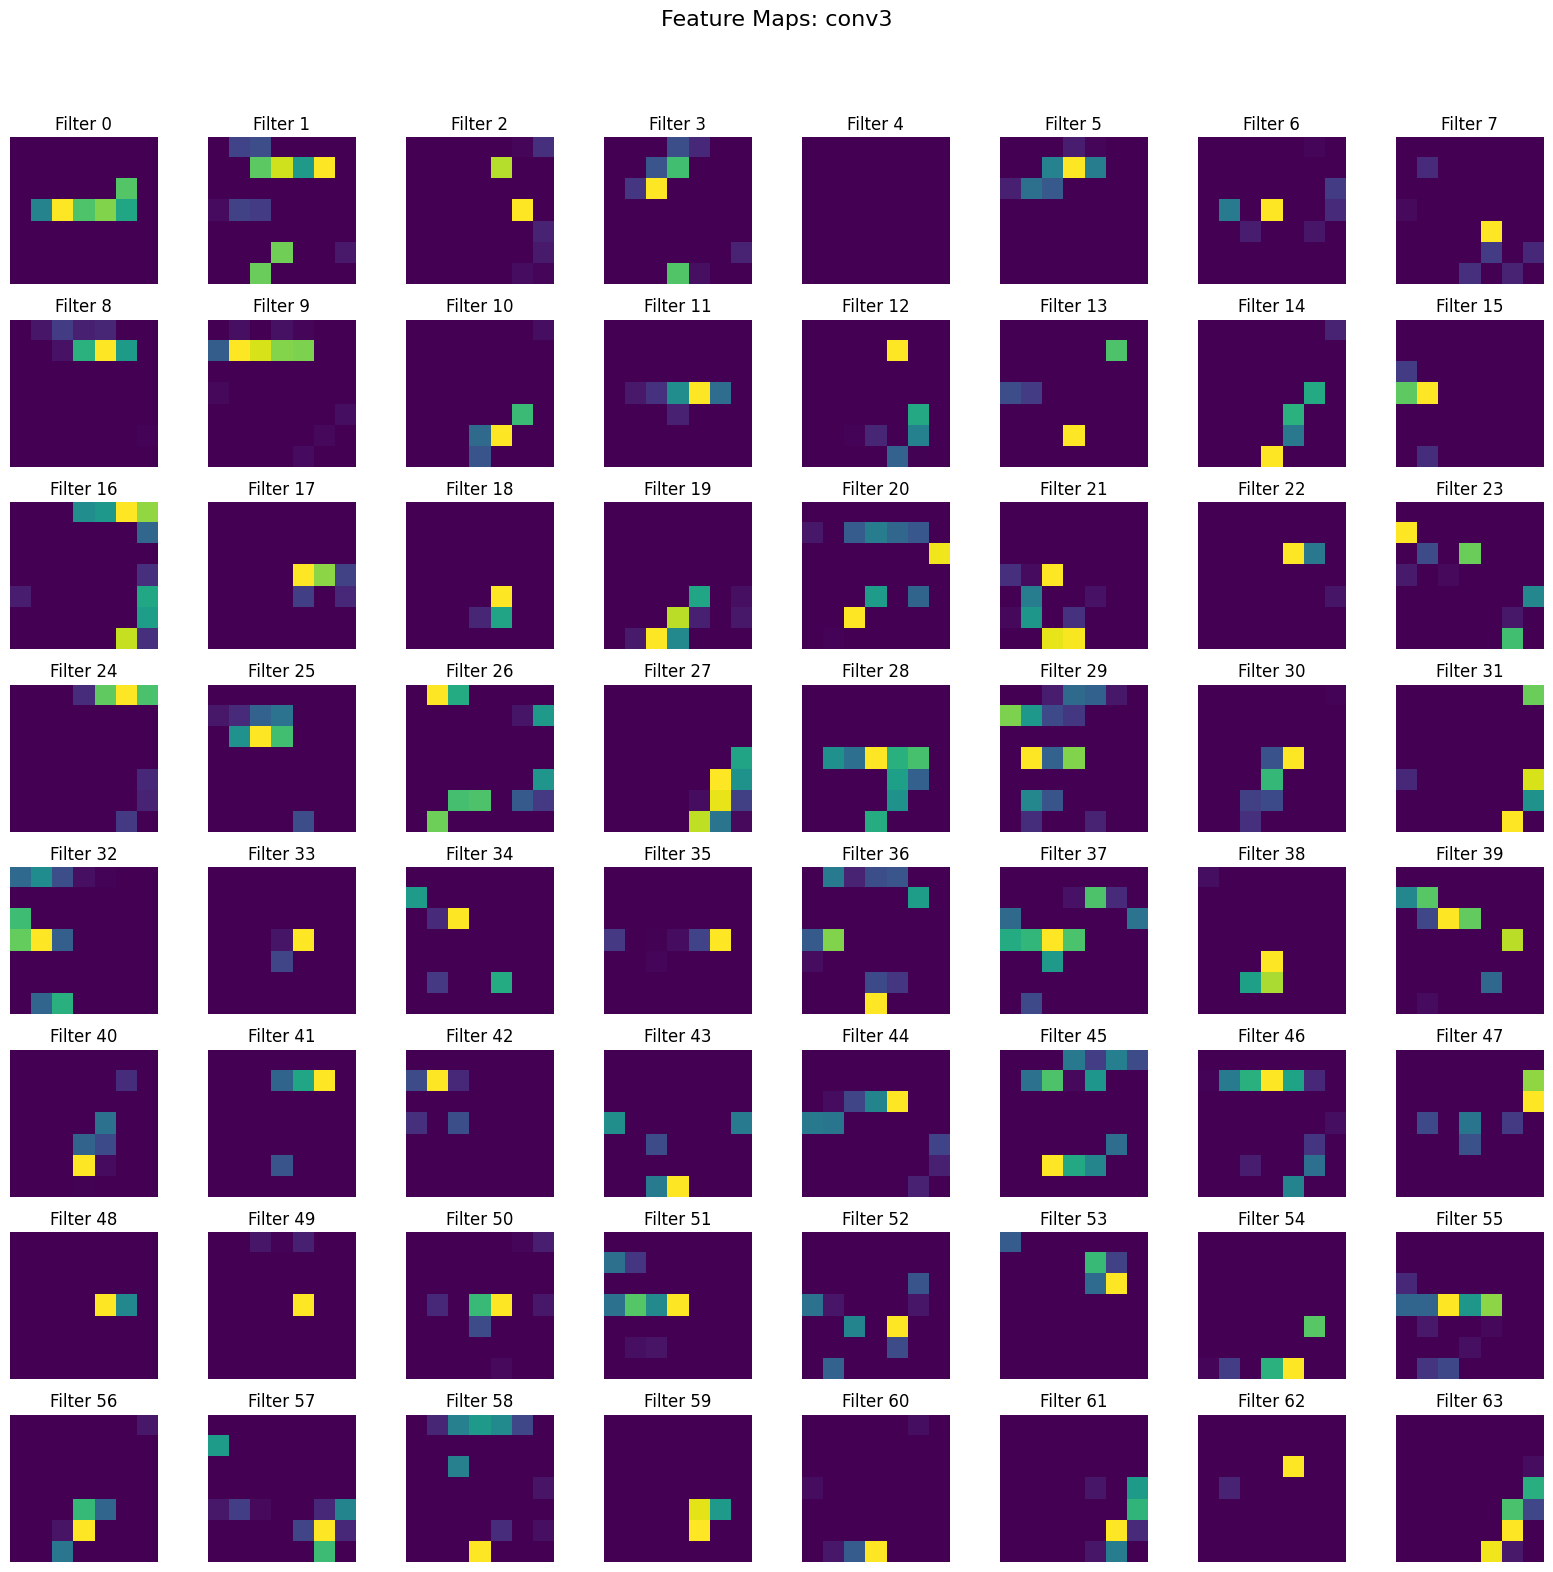

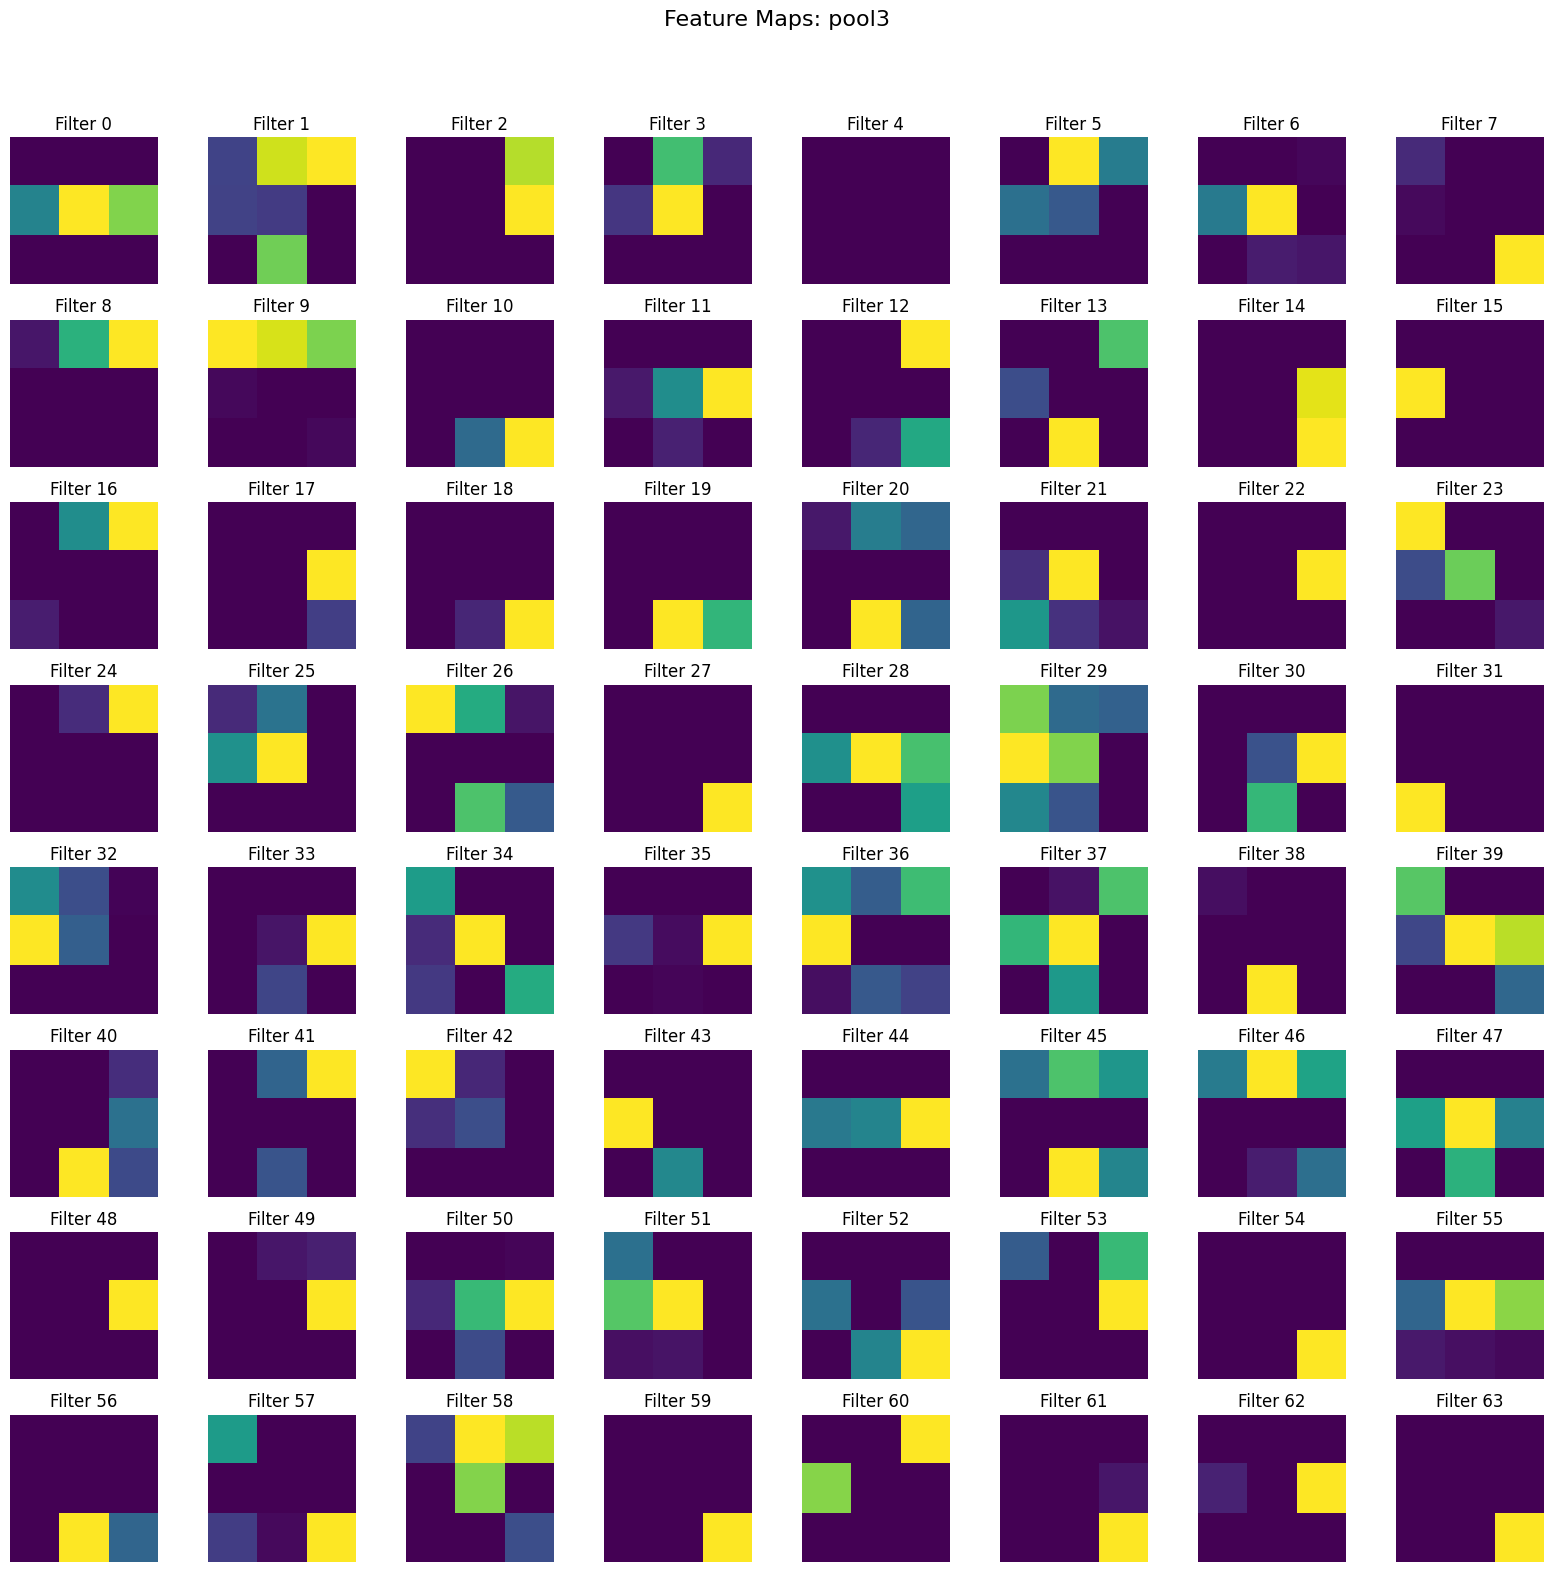

In [162]:
visualize_feature_maps(model)

Feature Map Analysis:

- Early layers (conv1, pool1) detect basic features like edges and corners
- Later layers (conv2, pool2) combine these to detect more complex patterns
- Bright areas show where the filter strongly activated for that specific feature
- Different feature maps activate for different aspects of the digit's shape
- Some feature maps remain mostly inactive, suggesting they specialize in features not present in this example

## 3. Confusion Matrix Visualization

In [165]:
# 3. Confusion Matrix Visualization
def visualize_confusion_matrix():
    # Generate predictions for test data
    predictions = model.predict(x_test)
    y_pred = np.argmax(predictions, axis=1)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Find most confused digit pairs
    off_diag = np.where(~np.eye(10, dtype=bool))
    confused_pairs = [(i, j, cm[i, j]) for i, j in zip(off_diag[0], off_diag[1])]
    confused_pairs.sort(key=lambda x: x[2], reverse=True)
    
    print("Most confused digit pairs (true, predicted, count):")
    for true, pred, count in confused_pairs[:5]:
        print(f"  {true} misclassified as {pred}: {count} times")
    
    # Visualize examples of confused digits
    top_confused = confused_pairs[0]  # The most confused pair
    true_digit, pred_digit, _ = top_confused
    
    # Find indices of the confused examples
    confused_indices = np.where((y_test == true_digit) & (y_pred == pred_digit))[0]
    
    if len(confused_indices) > 0:
        # Show a few examples
        n_examples = min(5, len(confused_indices))
        plt.figure(figsize=(15, 3))
        for i in range(n_examples):
            plt.subplot(1, n_examples, i+1)
            plt.imshow(x_test[confused_indices[i]].reshape(28, 28), cmap='gray')
            plt.title(f'True: {true_digit}, Pred: {pred_digit}')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    return true_digit, pred_digit

313/313 [==============================] - 1s 4ms/step


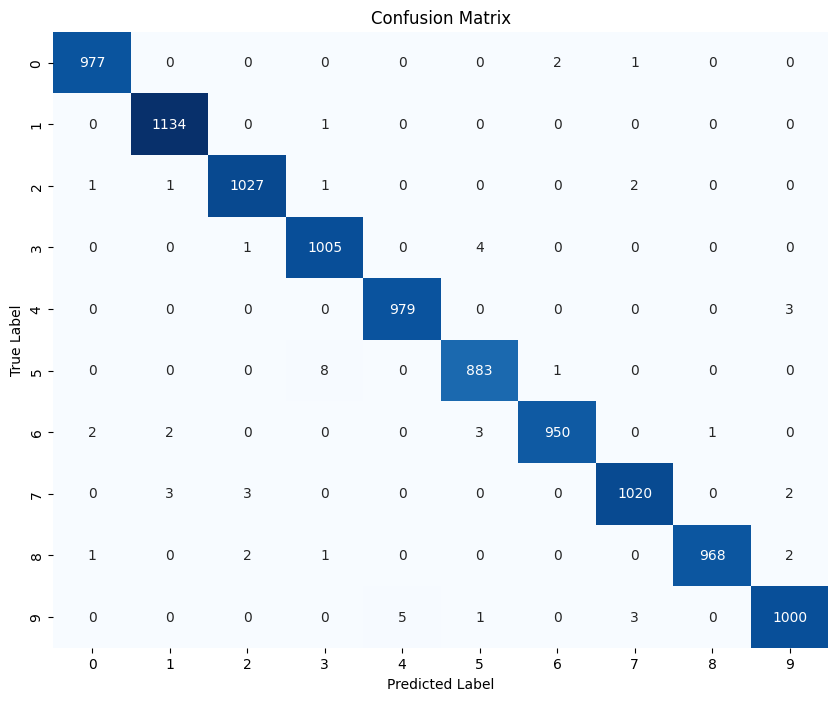

Most confused digit pairs (true, predicted, count):
  5 misclassified as 3: 8 times
  9 misclassified as 4: 5 times
  3 misclassified as 5: 4 times
  4 misclassified as 9: 3 times
  6 misclassified as 5: 3 times


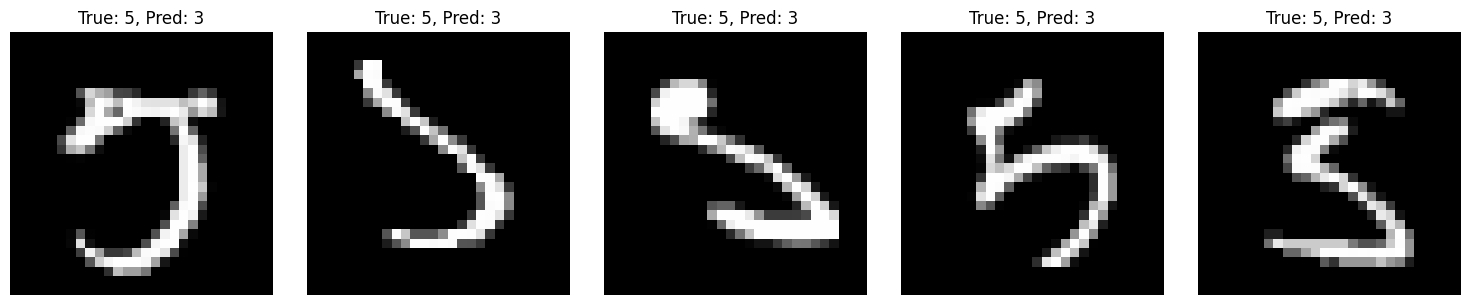

In [166]:
true_digit, pred_digit = visualize_confusion_matrix()

In [167]:
print(f"""
    Confusion Matrix Analysis:
    
    - Most common confusion: Digit {true_digit} misclassified as {pred_digit}
    - This confusion often occurs because these digits share similar visual features
    - The model achieves high overall accuracy, but struggles with specific digit pairs
    - Examining these confused examples helps understand model limitations
    """)


    Confusion Matrix Analysis:
    
    - Most common confusion: Digit 5 misclassified as 3
    - This confusion often occurs because these digits share similar visual features
    - The model achieves high overall accuracy, but struggles with specific digit pairs
    - Examining these confused examples helps understand model limitations
    


## 4. Class Activation Mapping 

In [169]:
def visualize_class_activation_fixed(model, img_idx=12):
    """Visualize what parts of the image the model is focusing on for classification"""
    # Get a test image
    img = x_test[img_idx:img_idx+1]
    true_label = y_test[img_idx]
    
    # Create a model that outputs the activations from the last convolutional layer
    last_conv_layer = model.get_layer('conv3')
    conv_model = tf.keras.Model(inputs=model.input, outputs=last_conv_layer.output)
    
    # Get intermediate dense layer
    dense_layer = model.get_layer('dense1')
    dense_model = tf.keras.Model(inputs=model.input, outputs=dense_layer.output)
    
    # Get the conv activations
    conv_activations = conv_model.predict(img)
    
    # Get the predicted class
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions[0])
    
    # Get the gradient of the predicted class with respect to the conv layer output
    grad_model = tf.keras.Model(
        inputs=model.input,
        outputs=[conv_model.output, model.output]
    )
    
    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Get both the conv activations and predictions
        conv_output, predictions = grad_model(img)
        # Get the loss for the predicted class
        loss = predictions[:, predicted_class]
    
    # Get the gradients with respect to the conv output
    grads = tape.gradient(loss, conv_output)
    
    # Global average pooling on the gradients (gradient-weighted class activation map)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Create the heatmap by multiplying each channel by its gradient importance
    heatmap = tf.zeros_like(conv_output[0, :, :, 0])
    for i in range(pooled_grads.shape[0]):
        heatmap += conv_output[0, :, :, i] * pooled_grads[i]
    
    # For visualization, we normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    
    # Resize the heatmap to the original image size
    heatmap_resized = tf.image.resize(
        tf.expand_dims(tf.expand_dims(heatmap, axis=0), axis=-1),
        (28, 28)
    ).numpy().squeeze()
    
    # Display the results
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    ax1.imshow(img.reshape(28, 28), cmap='gray')
    ax1.set_title(f'Original (Digit: {true_label})')
    ax1.axis('off')
    
    # CAM heatmap
    ax2.imshow(heatmap_resized, cmap='jet')
    ax2.set_title(f'Class Activation Map for Digit {predicted_class}')
    ax2.axis('off')
    
    # Overlay heatmap on original image
    ax3.imshow(img.reshape(28, 28), cmap='gray')
    ax3.imshow(heatmap_resized, cmap='jet', alpha=0.5)
    ax3.set_title('Overlay')
    ax3.axis('off')
    
    plt.tight_layout()
    plt.show()

    return true_label, predicted_class

1/1 [==============================] - 0s 12ms/step


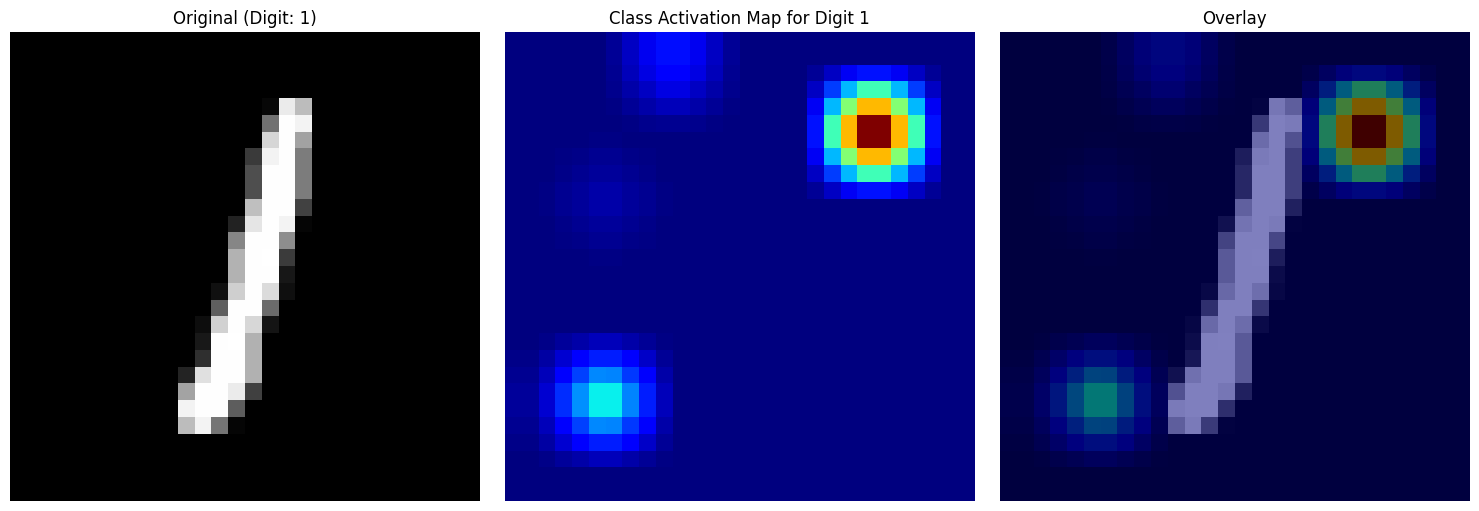

1/1 [==============================] - 0s 17ms/step


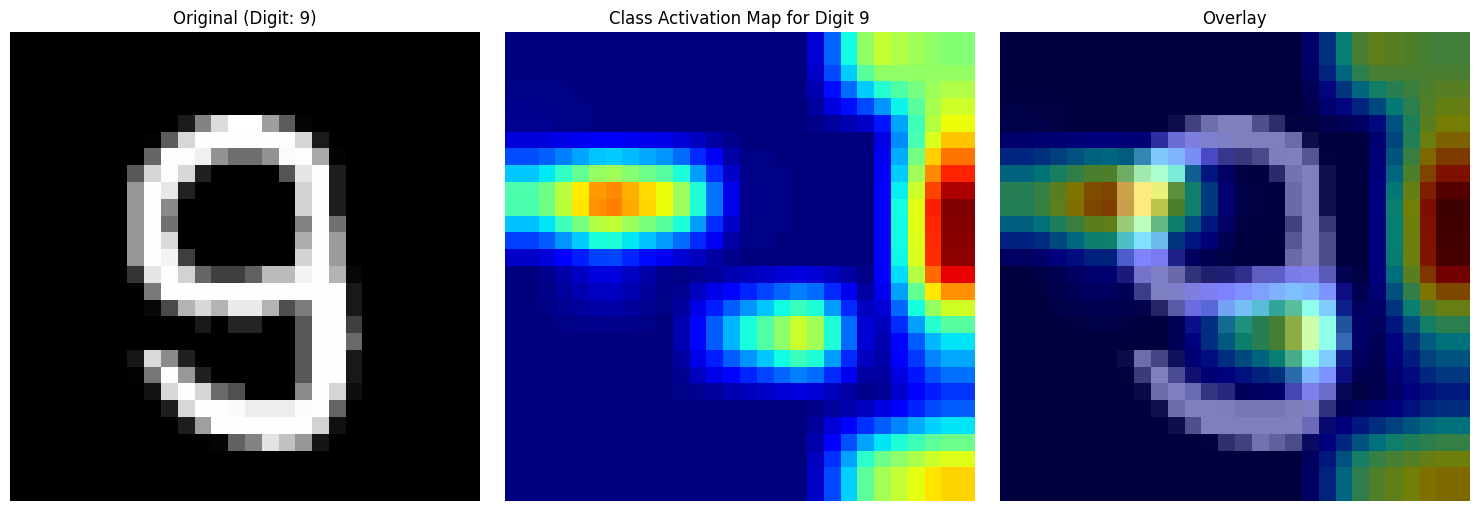

1/1 [==============================] - 0s 15ms/step


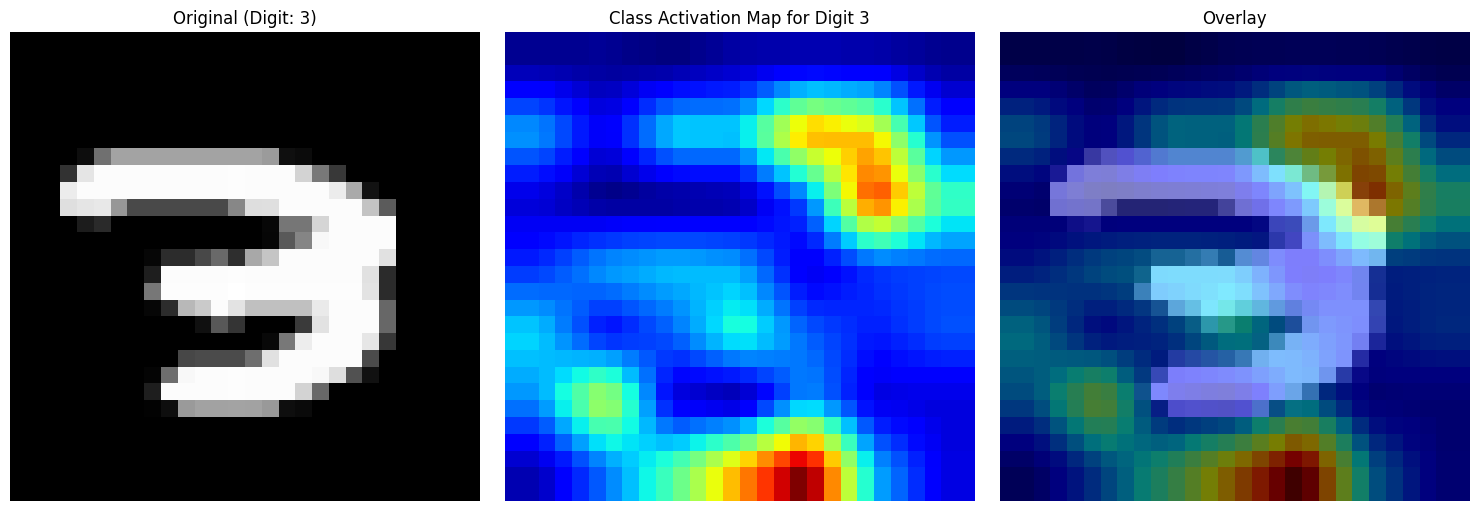

In [170]:
# Try the fixed CAM visualization on a few different digits
for i in range(3):
    try:
        true_label, predicted_class = visualize_class_activation_fixed(model, img_idx=np.random.randint(0, len(x_test)))
    except Exception as e:
        print(f"Error: {e}")
        # Try with a known good index
        print("Trying with a default index instead...")
        true_label, predicted_class = visualize_class_activation_fixed(model, img_idx=42)

In [171]:
print(f"""
    Class Activation Map Analysis:
    
    - True label: {true_label}, Predicted label: {predicted_class}
    - The heatmap shows which parts of the image were most important for the model's classification
    - Warmer colors (red/yellow) indicate areas with higher activation/importance
    - Cooler colors (blue) show areas the model largely ignored
    - The model focuses most on the distinctive features of the digit
    """)


    Class Activation Map Analysis:
    
    - True label: 3, Predicted label: 3
    - The heatmap shows which parts of the image were most important for the model's classification
    - Warmer colors (red/yellow) indicate areas with higher activation/importance
    - Cooler colors (blue) show areas the model largely ignored
    - The model focuses most on the distinctive features of the digit
    


## 5. t-SNE Visualization of Feature Space

In [173]:
# 5. t-SNE Visualization of Feature Space
def visualize_embedding():
    print("Generating t-SNE visualization of the feature space...")
    
    # Create a model that outputs features from the dense layer before classification
    feature_model = Model(inputs=model.input, outputs=model.get_layer('dense1').output)
    
    # Extract features for a subset of test images (for speed)
    sample_size = 2000
    indices = np.random.choice(len(x_test), sample_size, replace=False)
    features = feature_model.predict(x_test[indices])
    labels = y_test[indices]
    
    # Apply t-SNE dimensionality reduction
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)
    
    # Plot the 2D t-SNE embeddings
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(
        features_2d[:, 0], features_2d[:, 1], 
        c=labels, cmap='tab10', 
        alpha=0.7, s=10
    )
    plt.colorbar(scatter, ticks=range(10))
    plt.title('t-SNE Visualization of MNIST Digit Features')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

Generating t-SNE visualization of the feature space...
63/63 [==============================] - 0s 4ms/step


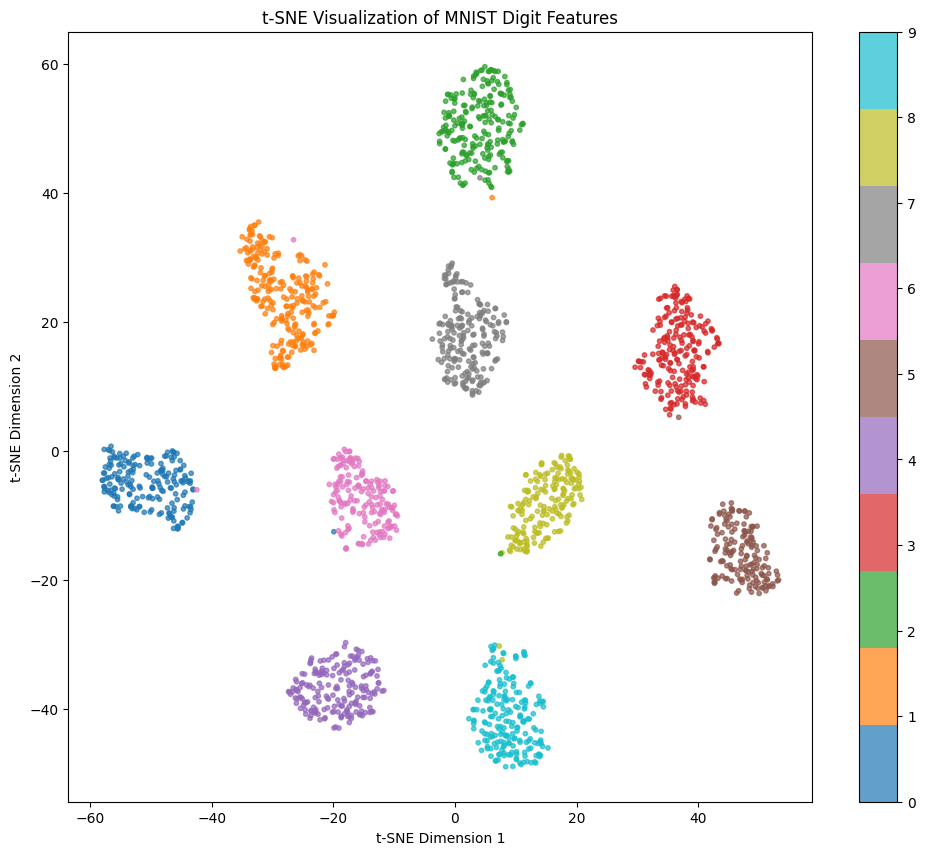

In [174]:
visualize_embedding()

t-SNE Visualization Analysis:
    
- Each point represents a digit image projected into 2D space
- Colors indicate the digit class (0-9)
- Clustered points show digits that the model represents similarly in its feature space
- Well-separated clusters indicate the model effectively distinguishes between these digit classes
- Overlapping clusters suggest the model has difficulty separating these digit classes
- This visualization helps understand how the model's internal representation groups similar digits

## Conclusion

#### Why Visualization and Analysis Matter for Neural Networks:

1. Interpretability: Visualizations help understand what features the model is learning 
   and how it makes decisions, turning the "black box" into a more understandable system.

2. Debugging and Improvement: Identifying where and why the model makes mistakes allows 
   targeted improvements to the architecture or training process.

3. Feature Understanding: Visualizing filters and activations reveals what patterns the 
   network recognizes at different layers, from simple edges to complex digit shapes.

4. Validation: Confirming that the model is learning meaningful features rather than 
   exploiting dataset quirks or shortcuts increases confidence in its generalizability.

5. Education: These visualizations provide intuitive understanding of how CNNs work, 
   making deep learning concepts more accessible.

For MNIST specifically:
- Filter visualizations show how the network learns to detect edges and curves critical for digit recognition
- Confusion matrices reveal which digits are most commonly confused (often 4/9, 3/8, and 5/3)
- Activation maps illustrate how the network progressively builds more complex representations of digits
- Class activation maps show which parts of the image are most important for classification